In [1]:
#standard import
import pandas as pd
import pandas_datareader.data as pdr
import datetime as dt
import yfinance as yf
import numpy as np
import scipy
from scipy.stats import kurtosis,skew,norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from scipy.optimize import LinearConstraint, Bounds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.mlab as mlab

In [2]:
#import tickers data
stock_list = ['FXE', 'EWJ', 'GLD', 'QQQ', 'SPY', 'SHV', 'DBA', 'USO','XBI', 'ILF', 'EPP', 'FEZ'] 
start_time = dt.datetime(2007, 3, 1)
end_time = dt.datetime(2020, 6, 30)
df = pdr.get_data_yahoo(stock_list, start_time, end_time)

In [3]:
#import factor data
factors = pd.read_csv('F-F_Research_Data_Factors_daily.csv',skiprows = 4)
factors.drop(factors.tail(1).index,inplace = True) 
factors[factors.columns[0]] = pd.to_datetime(factors[factors.columns[0]], format = '%Y%m%d')
factors.index = factors[factors.columns[0]]
factors.index.name = 'Date'
factors = factors.drop(columns = factors.columns[0])
factors = factors['2007-03-01':'2020-06-29']
factors.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2007-03-01,-0.25,-0.11,0.15,0.019
2007-03-02,-1.24,-0.64,0.24,0.019
2007-03-05,-1.11,-0.68,-0.28,0.019
2007-03-06,1.58,0.64,-0.02,0.019
2007-03-07,-0.21,-0.11,0.07,0.019


In [4]:
#combine the full data and drop Na values
full_data = pd.concat([df['Adj Close'], factors], axis = 1)
full_data = full_data.dropna()
full_data.to_csv(r'full_data.csv')
factor_data = full_data.loc[:, "Mkt-RF":][1:]
etf_data = full_data.loc[:, :"FEZ"]
etf_return = etf_data.pct_change()[1:]

---------------------------------------------------------------------------------------------------------------

In [5]:
#function that get weight for the portfolio

def get_Weight(return_r, factor_r, return_v, factor_v, beta_T, weight_p):
    
    #data to compute rho
    RF_r = np.array(factor_r['RF'])
    all_factor_r = factor_r.loc[:,'Mkt-RF':'HML'].to_numpy()
    SPY_r = np.array(return_r['SPY'])
    return_i = np.array(return_r)
    
    #get beta of each ticker
    var_m = np.var(SPY_r)
    beta_i_list = []
    for i in range(0, 12):
        beta_i_list.append(np.cov(return_i[:,i], SPY_r)[1,0] / var_m)
    beta_i_list = np.array(beta_i_list)
        
    
    #get coefficient
    X_r = all_factor_r
    y_r = return_i - RF_r.reshape(-1,1)
    regression_r = LinearRegression().fit(X_r,y_r)
    alpha_r = regression_r.intercept_
    B_r = regression_r.coef_
    
    #get rho
    rho = alpha_r + B_r.dot(X_r.T[:,-1]) + RF_r[-1]  
    
    #data to compute cov
    RF_v = np.array(factor_v['RF'])
    all_factor_v = factor_v.loc[:,'Mkt-RF':'HML'].to_numpy()
    SPY_v = np.array(return_v['SPY'])
    return_v = np.array(return_v)
    
    #get beta of each ticker
    var_m_v = np.var(SPY_v)
    beta_i_v_list = []
    for i in range(0, 12):
        beta_i_v_list.append(np.cov(return_v[:,i], SPY_v)[1,0] / var_m_v)
    beta_i_v_list = np.array(beta_i_v_list)
        
    #get coefficient    
    y_v = return_v - RF_v.reshape(-1,1)
    X_v = all_factor_v
    regression_v = LinearRegression().fit(X_v,y_v)
    alpha_v = regression_v.intercept_
    B_v = regression_v.coef_
    
    #get cov_rt_v
    eps_v = y_v.T - alpha_v.reshape(-1,1) - B_v.dot(X_v.T)
    eps_cov = np.cov(eps_v)
    eps_diag_v  = np.diag(eps_cov)
    D_v = np.diag(eps_diag_v)
    omega = np.cov(X_v.T)
    cov_rt_v = B_v.dot(omega).dot(B_v.T) + D_v
    
    #optimize weight
    result  = np.array([1/12] * 12)
    constrain_1 = LinearConstraint(beta_i_v_list,beta_T, beta_T)
    constrain_2 = LinearConstraint(np.array([1] * 12),1, 1)
    bound = Bounds(-2, 2, keep_feasible = True)
    def opt_f(weight):
        return - rho.dot(weight) + 0.5 * (weight - weight_p).dot(cov_rt_v.dot(weight - weight_p))
    result = minimize(opt_f, result, bounds = bound, constraints = [constrain_1, constrain_2])
    
    #return result
    return result.x  

In [6]:
#function to perform back test and return the list of returns
def back_test(data_factor, etf_return, return_term, variance_term, beta_T):
    
    #initialize
    p_return_list = []
    next_balance_date = max(return_term, variance_term) - 1
    current_weight = np.array([1/12] * 12)
    
    #compute returns
    for i in range(0, len(etf_return)):
        current_all_return = np.array(etf_return.iloc[i,:])
        p_return_list.append(current_weight.dot(current_all_return))
        
        #balance weight
        if(i == next_balance_date):
            current_weight = get_Weight(return_r = etf_return.iloc[i + 1 - return_term: i + 1], 
                                        factor_r = data_factor.iloc[i + 1 - return_term: i + 1],
                                        return_v = etf_return.iloc[i + 1 - variance_term: i + 1],
                                        factor_v = data_factor.iloc[i + 1 - variance_term: i + 1],
                                         beta_T = beta_T, weight_p = current_weight)
            next_balance_date == next_balance_date + 5
        else:
            continue       
    return p_return_list

In [7]:
#function that compute performance
def compute_performance_table(data_return, principal):
    year_b_day = 250
    
    #cumulative  return
    cum_return = year_b_day * np.cumprod((data_return + 1)).iloc[-1, 0] / len(data_return)
    
    #daily mean return
    ari_mean_return = np.mean(data_return)[0]
    
    #geometric mean return
    geo_mean_return = year_b_day * (np.power(np.cumprod(data_return + 1).iloc[-1 , 0], 1/len(data_return)) - 1)
    
    #daily min return
    daily_min_return = (year_b_day * np.min(data_return))[0]
    
    #max 10 days drawdown
    all_cum_return =  np.cumprod((data_return + 1))
    roll_max = all_cum_return.rolling(window = 10).max()
    drawdown = float(np.min(all_cum_return/roll_max - 1)[0])
    
    #volatility
    vol = (year_b_day * np.std(data_return))[0]
    
    #sharpe ratio
    sharpe_ratio = ari_mean_return / vol

    #skewness Kurtosis
    skewness = skew(data_return)[0]
    kurtosis_stats = kurtosis(data_return)[0]
    
    #modified VaR, CVaR with 95% confidence level
    z = norm.ppf(0.05)
    t = z + 1/6*(z**2 - 1)*skewness + 1/24*(z**3 - 3*z)*kurtosis_stats - 1/36*(2*z**3 - 5*z)*skewness**2
    modified_VaR = principal * (np.mean(data_return) + t*np.std(data_return)) * np.sqrt(year_b_day)
    C_VaR = principal * np.mean(data_return[data_return <= np.quantile(data_return, 0.05)])[0] * np.sqrt(year_b_day)
       
    result = pd.DataFrame(data = [cum_return, ari_mean_return, geo_mean_return, daily_min_return,
                           drawdown, vol, sharpe_ratio, skewness, kurtosis_stats,
                           modified_VaR[0], C_VaR],
                          index = ['cum_return', 'ari_mean_return', 'geo_mean_return', 'daily_min_return',
                           'drawdown', 'vol', 'sharpe_ratio', 'skewness', 'kurtosis',
                           'modified_VaR', 'C_VaR'],
                           columns = ['statistics'])
    return result  

In [8]:
#function that operate data to get tables
def get_table(return_data, factor_data, look_back_p, beta_l):
    return_table = pd.DataFrame([])
    performance_table = pd.DataFrame([])
    for look_back in look_back_p:
        for beta in beta_l:
            test_result = back_test(data_factor = factor_data, etf_return = return_data, 
                                    return_term = look_back[0], variance_term = look_back[1], 
                                     beta_T = beta)
            p_return_result = pd.DataFrame(test_result, index = pd.to_datetime(return_data.index))      
            p_porformance = compute_performance_table(data_return = p_return_result, 
                                              principal = 100)
            return_table = pd.concat([return_table, p_return_result], axis = 1)
            performance_table = pd.concat([performance_table, p_porformance], axis = 1)
    
    return_result = pd.concat([return_table, return_data['SPY']], axis = 1)
    SPY_performance = compute_performance_table(data_return = pd.DataFrame(return_data['SPY']), 
                                              principal = 100)
    performance_result = pd.concat([performance_table,SPY_performance], axis = 1)
    list_names = ['E[r]_40,Cov_40'] * 6 + ['E[r]_80,Cov_80'] * 6 + ['E[r]_120,Cov_120'] * 6
    beta_names = ['beta= -1','beta=-0.5','beta=0', 'beta=0.5','beta=1.0','beta=1.5'] * 3
    return_result.columns = [list_names + ['SPY'],beta_names + ['']]  
    performance_result.columns = return_result.columns
    return return_result,  performance_result

In [9]:
# function that plot the computed result
def show_graphs(return_result, period):
    #return plot
    for j in [0, 6, 12]:
        plt.figure()
        for i in range(0,6):
            
            plt.plot(100 * np.cumprod(return_result.iloc[:,i+j]+1), label = return_result.columns[i+j][0] + 
                                                                        return_result.columns[i+j][1])
            plt.legend(bbox_to_anchor=(1.05, 1))
        plt.plot(100 * np.cumprod(return_result.iloc[:,-1]+1), label = return_result.columns[-1][0] + 
                                                                        return_result.columns[-1][1])
        plt.savefig('net_value_'+ period + '_'+str(int(j/6 + 1))+'.png', dpi=300, bbox_inches='tight')
        plt.legend(bbox_to_anchor=(1.05, 1))
        
    for j in [0, 6, 12]:
        graph_2 = plt.figure()
        ax = graph_2.add_subplot(111, projection = '3d')
        for i in range(0,6):
            z = [-1, -0.5,0, 0.5, 1, 1.5][i]
            x,y = np.histogram(return_result.iloc[:,i + j],bins = 50, density = True)
            y = (y[:-1]+y[1:])/2
            ax.bar(y, x, zs=z, zdir='y',width = 0.005,label =
                        return_result.columns[i+j][0]+return_result.columns[i+j][1])
            ax.legend()
            l = norm.pdf(y,np.mean(return_result.iloc[:,i+j]),
                     np.std(return_result.iloc[:,i+j])) 
            ax.plot(y,[z]*len(y),l,linewidth = 2.0)
        plt.savefig('return_distribution_'+ period + '_'+str(int(j/6 + 1)) +'.png', 
                    dpi=300, bbox_inches='tight')

In [10]:
#split data to before, during and after the crisis
before_etf_return = etf_return.loc[:"2008-03-01"]
before_factor_data = factor_data[:'2008-03-01']

during_etf_return = etf_return.loc["2008-03-02":"2010-06-30"]
during_factor_data = factor_data["2008-03-02":"2010-06-30"]

end_etf_return = etf_return.loc["2010-07-01":]
end_factor_data = factor_data["2010-07-01":]

whole_etf_return = etf_return
whole_factor_data = factor_data

look_back_period = [[40,40],[80,80],[120,120]]
beta_list = [-1,-0.5, 0, 0.5, 1, 1.5]

# Analysis before the crisis:
<p>define March 01, 2008 as the start of crisis.

In [11]:
#porformance table
return_result_before, performance_result_before = get_table(return_data = before_etf_return, 
                                                               factor_data = before_factor_data,
                                                              look_back_p = look_back_period, 
                                                               beta_l = beta_list)
performance_result_before.to_csv(r'performance_result_before.csv')
performance_result_before

E[r]_40,Cov_40                                      \
                       beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return             0.349318    0.349962    0.348200    0.343988   
ari_mean_return       -0.003150   -0.003120   -0.003089   -0.003059   
geo_mean_return       -1.033378   -1.031558   -1.036544   -1.048568   
daily_min_return     -50.741581  -52.458204  -54.172459  -55.885002   
drawdown              -0.411125   -0.411539   -0.414656   -0.421614   
vol                   10.977022   11.095254   11.370268   11.791756   
sharpe_ratio          -0.000287   -0.000281   -0.000272   -0.000259   
skewness              -0.420268   -0.449429   -0.437307   -0.392709   
kurtosis               2.259334    2.219412    2.118308    1.978838   
modified_VaR        -124.071723 -125.912352 -128.776030 -132.636068   
C_VaR               -159.729059 -162.317448 -166.715322 -171.761088   

                                         E[r]_80,Cov_80              \
                    beta=1.0    beta=1.5       beta= -1   beta=-0.5   
cum_return          0.337422    0.328631       0.859675    0.843531   
ari_mean_return    -0.003027   -0.002996       0.000123    0.000056   
geo_mean_return    -1.067608   -1.093683      -0.142055   -0.160852   
daily_min_return  -57.595684  -59.304358     -36.245782  -35.878100   
drawdown           -0.428677   -0.435841      -0.254004   -0.264231   
vol                12.344545   13.011869       9.287818    9.349380   
sharpe_ratio       -0.000245   -0.000230       0.000013    0.000006   
skewness           -0.328545   -0.257083       0.063820    0.105990   
kurtosis            1.825748    1.677811       1.924303    2.002704   
modified_VaR     -137.462903 -143.223858     -93.075344  -92.988610   
C_VaR            -177.448369 -185.095649    -132.106530 -130.907842   

                                                                  \
                      beta=0    beta=0.5    beta=1.0    beta=1.5   
cum_return          0.829118    0.810337    0.787002    0.760078   
ari_mean_return     0.000021   -0.000011   -0.000043   -0.000073   
geo_mean_return    -0.177937   -0.200650   -0.229613   -0.264112   
daily_min_return  -35.383721  -34.886547  -34.389560  -34.592714   
drawdown           -0.274235   -0.284137   -0.293995   -0.303741   
vol                 9.576979    9.960527   10.484088   11.125948   
sharpe_ratio        0.000002   -0.000001   -0.000004   -0.000007   
skewness            0.173208    0.251783    0.330177    0.399747   
kurtosis            2.121739    2.294025    2.498563    2.705784   
modified_VaR      -93.985617  -96.136718  -99.431907 -103.808836   
C_VaR            -132.278436 -136.205960 -142.462725 -152.293930   

                 E[r]_120,Cov_120                                              \
                         beta= -1  beta=-0.5     beta=0   beta=0.5   beta=1.0   
cum_return               1.848478   1.798036   1.737934   1.669250   1.593173   
ari_mean_return          0.002727   0.002564   0.002401   0.002237   0.002073   
geo_mean_return          0.618155   0.590640   0.556835   0.516746   0.470378   
daily_min_return       -15.154334 -14.492773 -13.830065 -14.844382 -16.290989   
drawdown                -0.224187  -0.195728  -0.166997  -0.142716  -0.138934   
vol                      5.654304   5.038358   4.676887   4.630072   4.907102   
sharpe_ratio             0.000482   0.000509   0.000513   0.000483   0.000422   
skewness                 0.195614   0.330375   0.422001   0.401767   0.289306   
kurtosis                 1.729361   1.952397   2.227656   2.349267   2.322542   
modified_VaR           -51.247216 -44.045821 -39.880057 -39.807468 -43.714710   
C_VaR                  -77.033920 -64.888181 -60.116413 -61.094487 -67.058140   

                                   SPY  
                   beta=1.5             
cum_return         1.510969   0.962264  
ari_mean_return    0.001909  -0.000062  
geo_mean_return    0.417729  -0.030254  
daily_min_return -17.7389

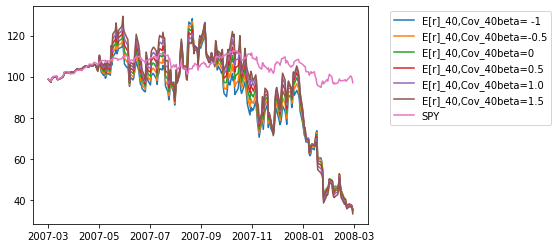

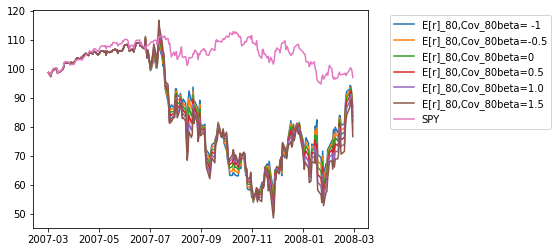

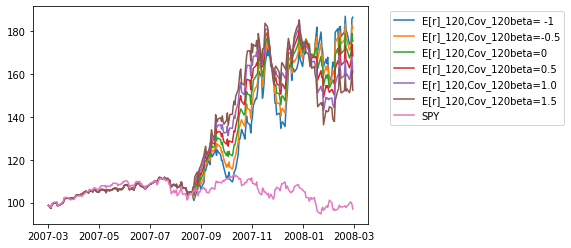

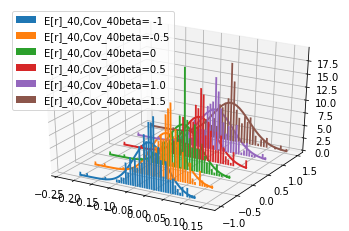

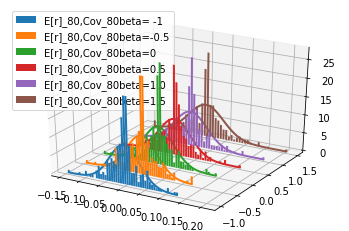

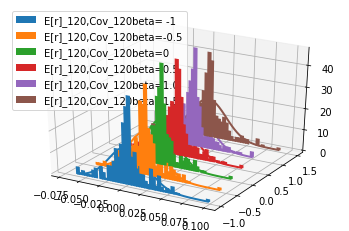

In [12]:
#graphs
show_graphs(return_result_before, 'before')

# Analysis during the crisis:
<p>define June 30, 2010 as the end of crisis

In [13]:
#porformance table
return_result_during, performance_result_during = get_table(return_data = during_etf_return, 
                                                               factor_data = during_factor_data,
                                                              look_back_p = look_back_period, 
                                                               beta_l = beta_list)
performance_result_during.to_csv(r'performance_result_during.csv')
performance_result_during

E[r]_40,Cov_40                                      \
                       beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return             0.065853    0.077893    0.087406    0.098143   
ari_mean_return        0.002836    0.002606    0.002418    0.002348   
geo_mean_return       -0.791716   -0.720540   -0.671684   -0.622550   
daily_min_return     -99.387676  -91.514762  -83.713520  -76.239711   
drawdown              -0.677242   -0.665432   -0.652477   -0.638098   
vol                   27.218971   26.009543   25.058536   24.368823   
sharpe_ratio           0.000104    0.000100    0.000096    0.000096   
skewness               0.121680    0.066809    0.008197   -0.048765   
kurtosis               1.639906    1.410486    1.226329    1.100814   
modified_VaR        -266.975035 -258.635828 -252.568705 -248.500639   
C_VaR               -379.017070 -368.285935 -359.902174 -352.501745   

                                         E[r]_80,Cov_80              \
                    beta=1.0    beta=1.5       beta= -1   beta=-0.5   
cum_return          0.104132    0.104483       0.007418    0.006416   
ari_mean_return     0.002277    0.002203      -0.004317   -0.004169   
geo_mean_return    -0.597426   -0.595998      -1.715422   -1.776693   
daily_min_return  -75.913861  -79.435365     -62.487062  -71.886726   
drawdown           -0.651233   -0.664240      -0.617794   -0.627181   
vol                23.903403   23.676120      17.696916   18.996136   
sharpe_ratio        0.000095    0.000093      -0.000244   -0.000219   
skewness           -0.099062   -0.134121       0.026436    0.044686   
kurtosis            1.023565    1.008693       2.471103    2.952681   
modified_VaR     -246.172750 -245.428123    -184.502237 -195.517803   
C_VaR            -347.932265 -347.188511    -273.185508 -298.439228   

                                                                  \
                      beta=0    beta=0.5    beta=1.0    beta=1.5   
cum_return          0.005209    0.003708    0.002398    0.001432   
ari_mean_return    -0.004063   -0.004080   -0.004107   -0.004134   
geo_mean_return    -1.864629   -2.008088   -2.191738   -2.409111   
daily_min_return  -85.296895  -97.376355 -109.709941 -122.043527   
drawdown           -0.635599   -0.663781   -0.697901   -0.729360   
vol                20.396897   21.975757   23.822196   25.834898   
sharpe_ratio       -0.000199   -0.000186   -0.000172   -0.000160   
skewness            0.076437    0.113849    0.158493    0.205402   
kurtosis            3.517164    4.022257    4.493496    4.913109   
modified_VaR     -206.639237 -219.250571 -233.793976 -249.426288   
C_VaR            -324.045590 -351.581830 -381.969673 -412.357515   

                 E[r]_120,Cov_120                                      \
                         beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return               0.012969    0.011724    0.010112    0.007457   
ari_mean_return         -0.002977   -0.002810   -0.002639   -0.002536   
geo_mean_return         -1.479422   -1.522065   -1.584585   -1.713191   
daily_min_return       -66.676181  -76.131808  -85.567023  -96.743269   
drawdown                -0.595023   -0.602203   -0.609511   -0.647679   
vol                     19.069136   20.104765   21.322929   22.982231   
sharpe_ratio            -0.000156   -0.000140   -0.000124   -0.000110   
skewness                 0.175160    0.165070    0.164982    0.171064   
kurtosis                 3.296695    3.604439    3.976405    4.354096   
modified_VaR          -188.984969 -198.312193 -208.779150 -223.173422   
C_VaR                 -292.782610 -312.480488 -334.709504 -364.048403   

                                                SPY  
                    beta=1.0    beta=1.5             
cum_return          0.004919    0.003011   0.346673  
ari_mean_return    -0.002460   -0.002384  -0.000130  
geo_mean_return    -1.888793   -2.095835  -0.086765  
daily_min_return -108.634789 -120.544368 -24.611927  
drawdown  

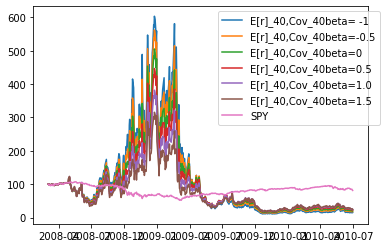

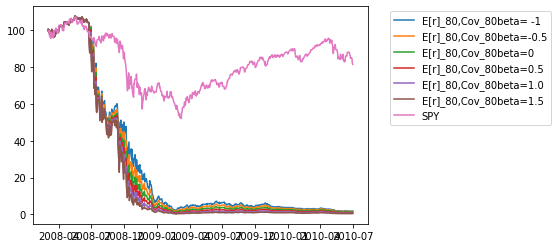

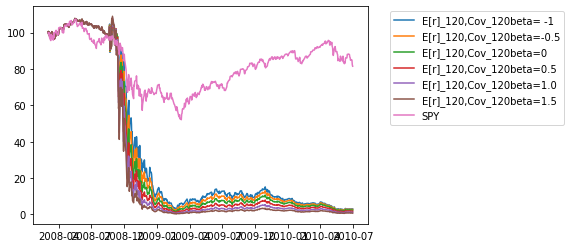

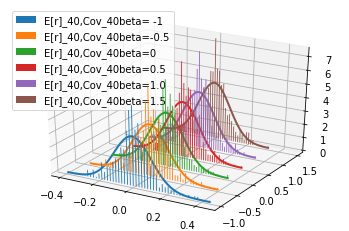

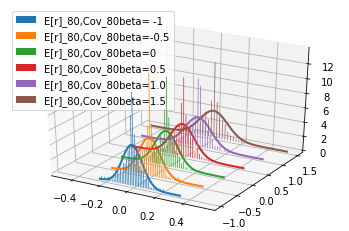

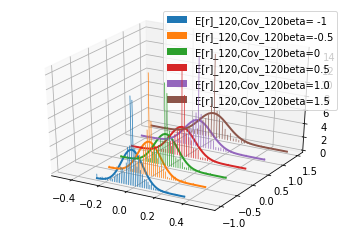

In [14]:
#graphs
show_graphs(return_result_during, 'during')

# Analysis after the crisis:

In [15]:
#porformance table
return_result_after, performance_result_after = get_table(return_data = end_etf_return, 
                                                               factor_data = end_factor_data,
                                                              look_back_p = look_back_period, 
                                                               beta_l = beta_list)
performance_result_after.to_csv(r'performance_result_after.csv')
performance_result_after

E[r]_40,Cov_40                                      \
                       beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return             0.011195    0.017812    0.026200    0.033705   
ari_mean_return        0.000680    0.000865    0.001050    0.001174   
geo_mean_return       -0.216848   -0.170740   -0.132420   -0.107404   
daily_min_return    -100.294195 -102.168693 -104.043301 -103.488769   
drawdown              -0.617421   -0.628389   -0.639391   -0.638390   
vol                   13.887121   13.881082   14.010655   14.101369   
sharpe_ratio           0.000049    0.000062    0.000075    0.000083   
skewness               0.182050    0.142396    0.102948    0.051971   
kurtosis               3.980329    4.010611    4.079926    4.028146   
modified_VaR        -131.737826 -132.344129 -134.185631 -136.268415   
C_VaR               -187.039284 -188.647948 -192.127784 -195.443211   

                                         E[r]_80,Cov_80              \
                    beta=1.0    beta=1.5       beta= -1   beta=-0.5   
cum_return          0.026739    0.037066       0.356198    0.339956   
ari_mean_return     0.001220    0.001451       0.002351    0.002400   
geo_mean_return    -0.130400   -0.097964       0.126890    0.122250   
daily_min_return -105.018779 -106.893501     -90.764233  -95.962235   
drawdown           -0.650875   -0.661116      -0.578081   -0.593711   
vol                14.690097   15.091407      15.182856   15.431740   
sharpe_ratio        0.000083    0.000096       0.000155    0.000156   
skewness            0.038315   -0.007170       0.193687    0.121813   
kurtosis            3.772834    4.046320       2.940981    2.956194   
modified_VaR     -142.803518 -147.101191    -143.175504 -147.511930   
C_VaR            -203.884033 -210.823498    -205.772579 -211.572591   

                                                                  \
                      beta=0    beta=0.5    beta=1.0    beta=1.5   
cum_return          0.361988    0.297923    0.161251    0.116112   
ari_mean_return     0.002521    0.002346    0.001952    0.001911   
geo_mean_return     0.128493    0.109130    0.048114    0.015478   
daily_min_return -100.371724 -103.325557 -119.917007 -136.371183   
drawdown           -0.603768   -0.572151   -0.634425   -0.726108   
vol                15.793325   15.365469   14.690905   14.993932   
sharpe_ratio        0.000160    0.000153    0.000133    0.000127   
skewness            0.084015   -0.027876   -0.205874   -0.312353   
kurtosis            3.338991    3.424518    3.860303    5.051940   
modified_VaR     -151.181663 -150.190226 -147.867863 -151.537770   
C_VaR            -217.021526 -212.906680 -207.993435 -216.124998   

                 E[r]_120,Cov_120                                      \
                         beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return               0.000068    0.000118    0.000135    0.000137   
ari_mean_return         -0.001796   -0.001559   -0.001532   -0.001543   
geo_mean_return         -0.722876   -0.668428   -0.655391   -0.653545   
daily_min_return       -59.366027  -57.413371  -57.513824  -57.928392   
drawdown                -0.462955   -0.455291   -0.454722   -0.454089   
vol                     11.684238   11.775288   11.635941   11.526908   
sharpe_ratio            -0.000154   -0.000132   -0.000132   -0.000134   
skewness                 0.087623    0.034801   -0.019406   -0.072060   
kurtosis                 1.227295    1.292245    1.175034    1.184174   
modified_VaR          -120.708807 -122.282794 -122.130516 -122.097655   
C_VaR                 -161.138093 -164.574793 -164.271111 -164.580822   

                                                SPY  
                    beta=1.0    beta=1.5             
cum_return          0.000129    0.000112   0.358471  
ari_mean_return    -0.001555   -0.001567   0.000569  
geo_mean_return    -0.659423   -0.673232   0.127522  
daily_min_return  -58.328518  -61.240612 -27.355903  
drawdown  

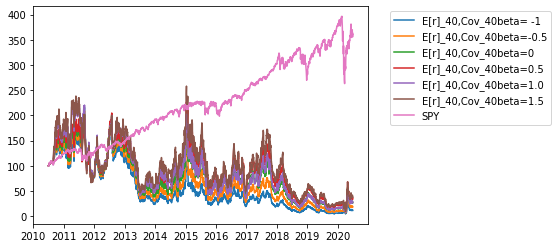

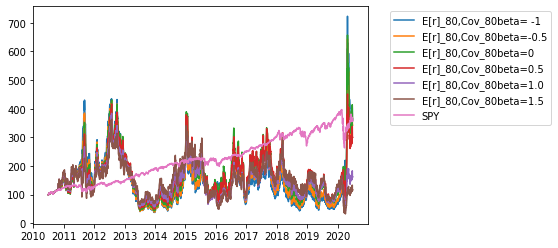

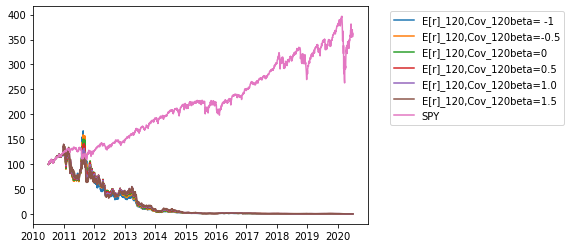

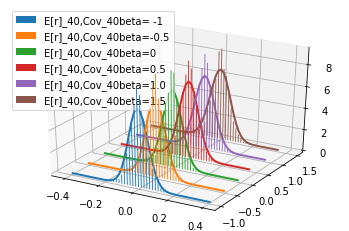

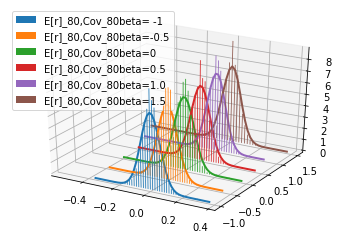

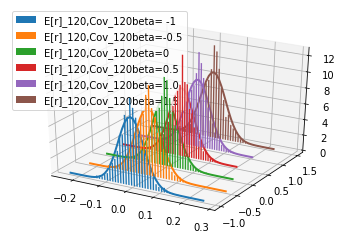

In [16]:
#graphs
show_graphs(return_result_after, 'after')

# Whole period Analysis:

In [17]:
#porformance table
return_result_whole, performance_result_whole = get_table(return_data = whole_etf_return, 
                                                               factor_data = whole_factor_data,
                                                              look_back_p = look_back_period, 
                                                               beta_l = beta_list)
performance_result_whole.to_csv(r'performance_result_whole.csv')
performance_result_whole

E[r]_40,Cov_40                                      \
                       beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return             0.200334    0.192255    0.167101    0.131579   
ari_mean_return        0.001977    0.002053    0.002128    0.002204   
geo_mean_return        0.073705    0.070638    0.060189    0.042383   
daily_min_return    -107.171091 -101.489797  -95.805369  -92.361453   
drawdown              -0.570979   -0.584086   -0.597986   -0.621057   
vol                   14.385399   14.751577   15.222611   15.789125   
sharpe_ratio           0.000137    0.000139    0.000140    0.000140   
skewness              -0.245735   -0.252839   -0.258154   -0.260257   
kurtosis               2.140186    2.160236    2.331837    2.650669   
modified_VaR        -148.847411 -152.740490 -157.409168 -162.688236   
C_VaR               -206.294591 -213.415619 -221.913889 -231.294563   

                                         E[r]_80,Cov_80              \
                    beta=1.0    beta=1.5       beta= -1   beta=-0.5   
cum_return          0.093733    0.060314       0.000012    0.000016   
ari_mean_return     0.002279    0.002354      -0.001451   -0.001320   
geo_mean_return     0.017115   -0.015728      -0.651678   -0.628377   
daily_min_return -102.541565 -112.723851     -72.857558  -67.993184   
drawdown           -0.676227   -0.726116      -0.409964   -0.435998   
vol                16.441259   17.169250      11.975583   12.164967   
sharpe_ratio        0.000139    0.000137      -0.000121   -0.000108   
skewness           -0.258510   -0.252908      -0.042549   -0.056811   
kurtosis            3.097009    3.641648       1.577210    1.613535   
modified_VaR     -168.445877 -174.584164    -125.377870 -127.371171   
C_VaR            -242.273314 -254.579907    -168.816583 -173.296004   

                                                                  \
                      beta=0    beta=0.5    beta=1.0    beta=1.5   
cum_return          0.000020    0.000022    0.000024    0.000023   
ari_mean_return    -0.001196   -0.001074   -0.000951   -0.000829   
geo_mean_return    -0.612823   -0.603224   -0.599459   -0.601695   
daily_min_return  -63.173221  -65.651299  -75.735033  -85.846395   
drawdown           -0.477682   -0.525735   -0.570812   -0.613083   
vol                12.469361   12.876389   13.378027   13.962392   
sharpe_ratio       -0.000096   -0.000083   -0.000071   -0.000059   
skewness           -0.066562   -0.069486   -0.064550   -0.052321   
kurtosis            1.758170    2.032068    2.442458    2.977803   
modified_VaR     -130.297354 -133.911703 -138.050050 -142.563234   
C_VaR            -179.271647 -186.380834 -194.037611 -202.821636   

                 E[r]_120,Cov_120                                      \
                         beta= -1   beta=-0.5      beta=0    beta=0.5   
cum_return               0.000829    0.001561    0.002635    0.003998   
ari_mean_return         -0.000830   -0.000692   -0.000553   -0.000414   
geo_mean_return         -0.334826   -0.287801   -0.248816   -0.217785   
daily_min_return       -65.536762  -64.444017  -63.329360  -66.312982   
drawdown                -0.583110   -0.560716   -0.537390   -0.531638   
vol                      7.911975    7.530934    7.393188    7.511874   
sharpe_ratio            -0.000105   -0.000092   -0.000075   -0.000055   
skewness                -0.477507   -0.394654   -0.382648   -0.443334   
kurtosis                 7.164172    6.221675    5.950616    6.161930   
modified_VaR           -82.964150  -78.661251  -77.127175  -78.703541   
C_VaR                 -120.266644 -113.478000 -110.649543 -111.745313   

                                                SPY  
                    beta=1.0    beta=1.5             
cum_return          0.005456    0.006696   0.212547  
ari_mean_return    -0.000274   -0.000135   0.000399  
geo_mean_return    -0.194656   -0.179411   0.078115  
daily_min_return  -72.421031  -78.506521 -27.355903  
drawdown  

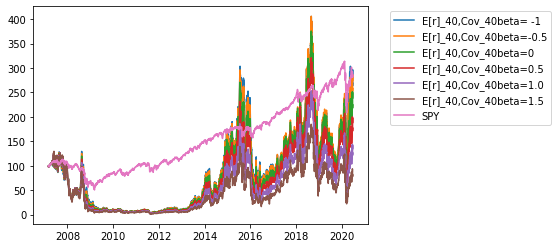

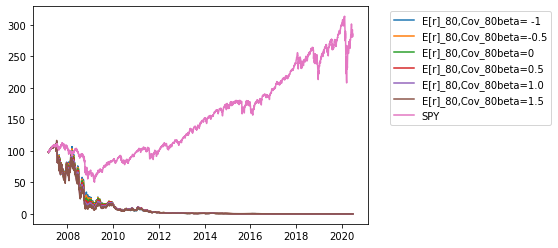

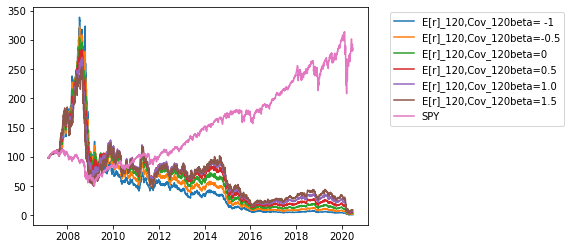

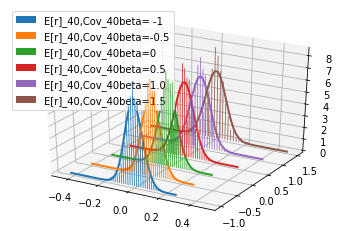

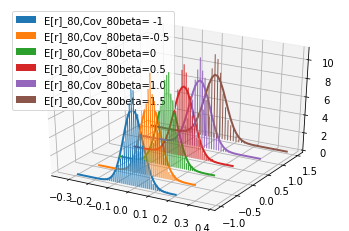

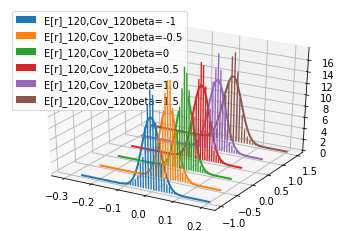

In [18]:
#graphs
show_graphs(return_result_whole, 'whole')